In [7]:
import pandas
import numpy
import matplotlib.pyplot as plt
import cv2
import os
import glob

def get_image_metadata(image_path):
    # get the image name
    image_name = os.path.basename(image_path)
    # get the metadata for that image
    image_metadata = metadata[metadata["strip_filename"] == image_name]
    return image_metadata

# get a list of all images in data/new_strips
images = glob.glob("roi_images/*.png")
print(f"Found {len(images)} images")

# load the metadata
metadata = pandas.read_csv("roi_metadata.csv")

# print the size of the metadata
print(f"Metadata contains {len(metadata)} images")

# print the image metadata for the first image
print(f"Image 0 metadata:")
print(get_image_metadata(images[0]))



Found 329 images
Metadata contains 346 images
Image 0 metadata:
   strip                                           filename  box_size    x  \
0      0  ./raw_images/2022-1-10_Wild Type_500uE 1 hour_...       200  596   

      y strip_filename  rotation_angle  x1  y1   x2   y2  
0  1664    strip_0.png      -38.990994  76  62  216  200  


# Project Overview


<img src="images/pld3280-fig-0001-m.jpg" width="800" height="600">

## Part 1. Thresholding the image strips

Load the custom strips into the notebook and threshold them to get the binary images.

In [5]:
def load_gray_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray


def equalize_image(image, clip_low=100, clip_high=255):
    equalized = cv2.equalizeHist(image)
    equalized = numpy.clip(equalized, clip_low, clip_high)
    return equalized

## Display our custom strips

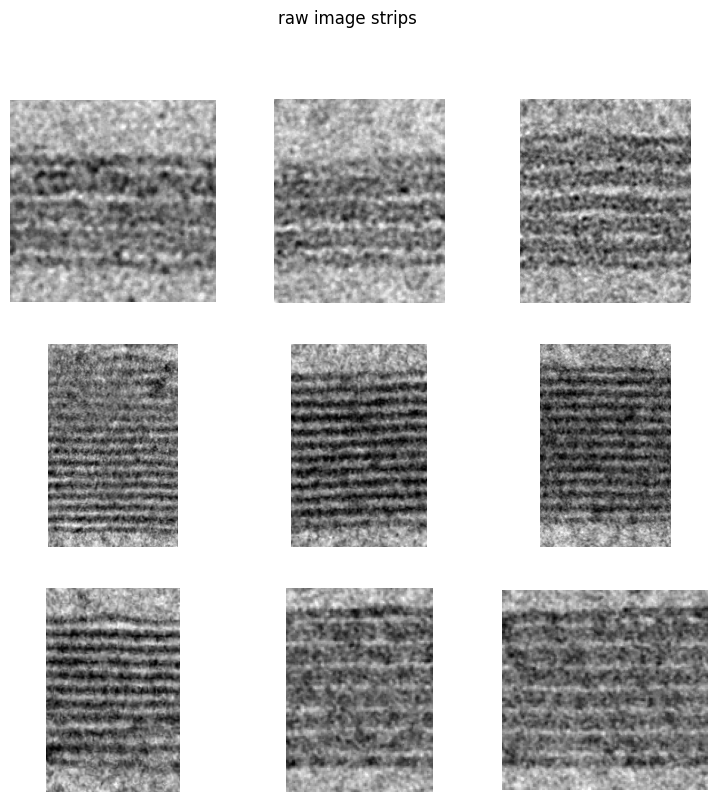

In [8]:
# plot all of the images in a grid
plt.figure(figsize=(9, 9))
plt.suptitle("raw image strips")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = load_gray_image(images[i])
    plt.imshow(image, cmap="gray")
    plt.axis("off")

## Display all of the strips, with balanced and clipped scale


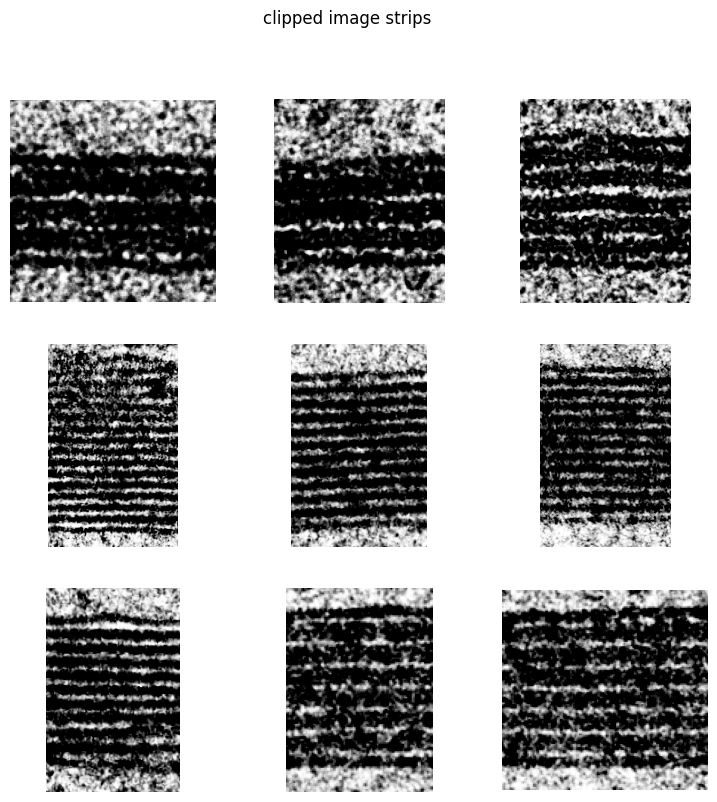

In [9]:
# plot all of the images in a grid
plt.figure(figsize=(9, 9))
plt.suptitle("clipped image strips")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = load_gray_image(images[i])
    image = equalize_image(image)
    plt.imshow(image, cmap="gray")
    plt.axis("off")

## Threshold the image using the Otsu method

The Otus method is a simple and effective way to threshold an image. It calculates the threshold value based on the histogram of the image. The threshold value is the value that minimizes the intra-class variance of the two classes.

Text(0.5, 1.0, 'Otsu Thresholded Image')

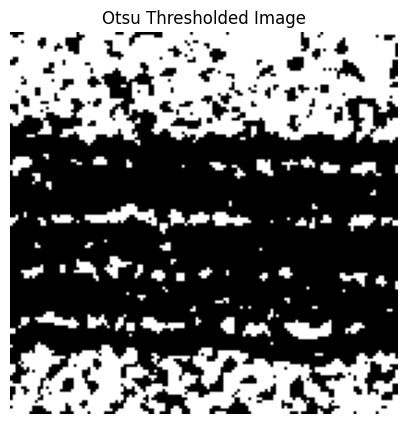

In [10]:
# threshold the image using a smart thresholding technique

def threshold_image(image, threshold_type=cv2.THRESH_BINARY, block_size=15, constant=2):
    _, thresholded = cv2.threshold(image, 0, 255, threshold_type + cv2.THRESH_OTSU)
    return thresholded

image = load_gray_image(images[0])
equalized = equalize_image(image)
thresholded = threshold_image(equalized)

# plot the thresholded image
plt.figure(figsize=(5, 5))
plt.imshow(thresholded, cmap="gray")
plt.axis("off")
plt.title("Otsu Thresholded Image")

## Cleaning the strips
Our strips are not perfect, so we need to clean them up a bit. We will use morphological operations to remove small noise and fill in small holes.

The main imperfections seem to be in the non-lumen areas. In the non-lumen (darker) areas, we have some small white spots that we need to remove. We can do this by using a morphological opening operation. This operation will remove small white spots in the image.

Text(0.5, 1.0, 'Closed Image')

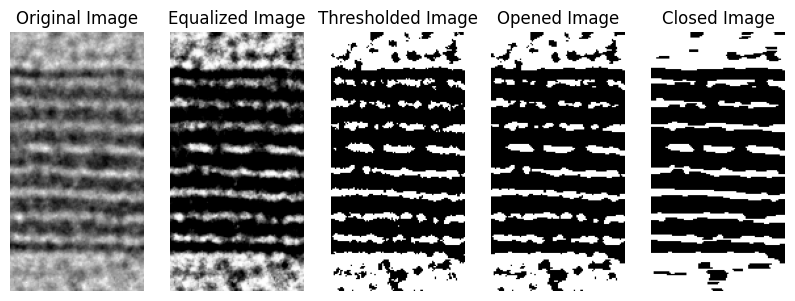

In [19]:
import random

# random image 
image_number = random.randint(0, len(images))
image = load_gray_image(images[image_number])

# process
equalized = equalize_image(image)
thresholded = threshold_image(equalized)

# create a custom kernel that is a line with a wider horizontal component, to detect the horizontal lines in the image
kernel = numpy.ones((1, 3), numpy.uint8)

# remove small white spots in the image
opening = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=1)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=3)

# plot the raw image, the thresholded image, and the opened image
plt.figure(figsize=(10, 10))
plt.subplot(1, 5, 1)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 5, 2)
plt.imshow(equalized, cmap="gray")
plt.axis("off")
plt.title("Equalized Image")

plt.subplot(1, 5, 3)
plt.imshow(thresholded, cmap="gray")
plt.axis("off")
plt.title("Thresholded Image")

plt.subplot(1, 5, 4)
plt.imshow(opening, cmap="gray")
plt.axis("off")
plt.title("Opened Image")

plt.subplot(1, 5, 5)
plt.imshow(closing, cmap="gray")
plt.axis("off")
plt.title("Closed Image")





## now we need to create contours for the objects, and filter out the small ones


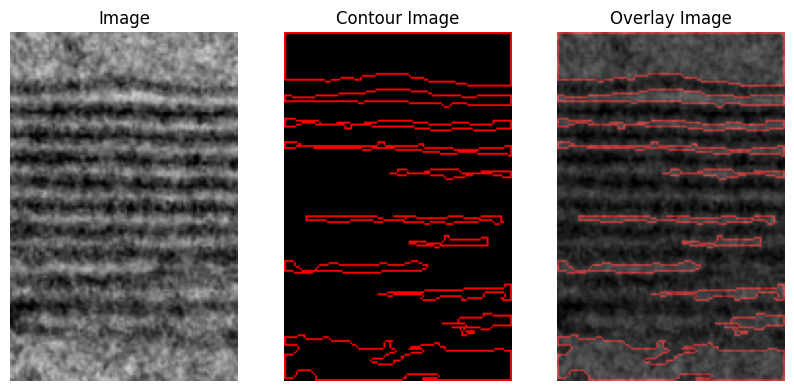

In [13]:
# find the contours in the image
contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# filter by area
min_area = 100
max_area = 1e100
filtered_contours = [c for c in contours if min_area < cv2.contourArea(c) < max_area]

# draw the contours on the image
contour_image = numpy.zeros_like(image)
cv2.drawContours(contour_image, filtered_contours, -1, (255, 255, 255), 1)

# create rgb copy of original image
rgb_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# create a red contour image
contour_image = numpy.zeros_like(rgb_image)

cv2.drawContours(contour_image, filtered_contours, -1, (255, 0, 0), 1)

# create an image with the RGB image and the contour image overlaid
overlay = cv2.addWeighted(rgb_image, 0.5, contour_image, 0.5, 0)

# plot the rgb_image, the contour image, and then the overlay
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.axis("off")
plt.title("Image")

plt.subplot(1, 3, 2)
plt.imshow(contour_image)
plt.axis("off")
plt.title("Contour Image")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.axis("off")
plt.title("Overlay Image")

plt.savefig("output/contours.png")

## Function to do all the things


In [14]:
def process_image_strip(image_path) -> dict:
    # load the image
    image = load_gray_image(image_path)

    print(f"Processing {image_path}")
    # equalize the image
    equalized = equalize_image(image)

    # threshold the image
    thresholded = threshold_image(equalized)

    # create a custom kernel that is a line with a wider horizontal component, to detect the horizontal lines in the image
    kernel = numpy.ones((1, 3), numpy.uint8)

    # remove small white spots in the image
    opening = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=1)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=3)

    # find the contours in the image
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # filter by area
    min_area = 100
    max_area = 1e100
    filtered_contours = [c for c in contours if min_area < cv2.contourArea(c) < max_area]

    return {"image": image, "equalized": equalized, "thresholded": thresholded, "closing": closing, "filtered_contours": filtered_contours}


roi_images\strip_0.png
Processing roi_images\strip_0.png
(138, 140)
(138, 140)
roi_images\strip_1.png
Processing roi_images\strip_1.png
(158, 132)
(158, 132)
roi_images\strip_10.png
Processing roi_images\strip_10.png
(197, 165)
(197, 165)
roi_images\strip_100.png
Processing roi_images\strip_100.png
(227, 144)
(227, 144)
roi_images\strip_101.png
Processing roi_images\strip_101.png
(183, 122)
(183, 122)
roi_images\strip_102.png
Processing roi_images\strip_102.png
(203, 130)
(203, 130)
roi_images\strip_103.png
Processing roi_images\strip_103.png
(179, 117)
(179, 117)
roi_images\strip_105.png
Processing roi_images\strip_105.png
(135, 97)
(135, 97)
roi_images\strip_106.png
Processing roi_images\strip_106.png
(135, 139)
(135, 139)
roi_images\strip_107.png
Processing roi_images\strip_107.png
(186, 115)
(186, 115)


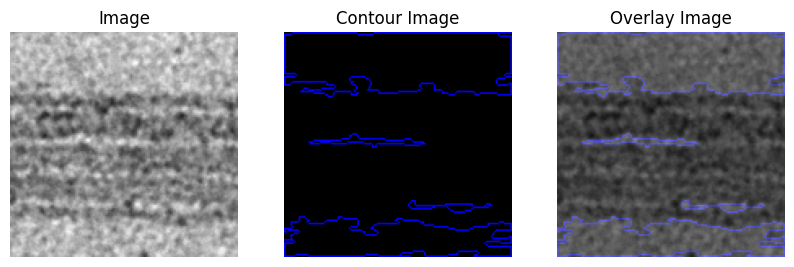

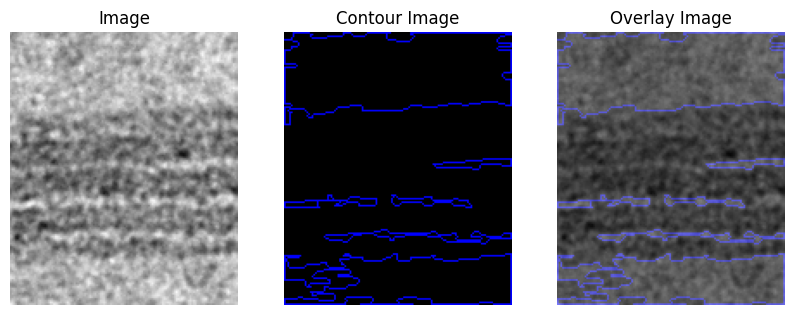

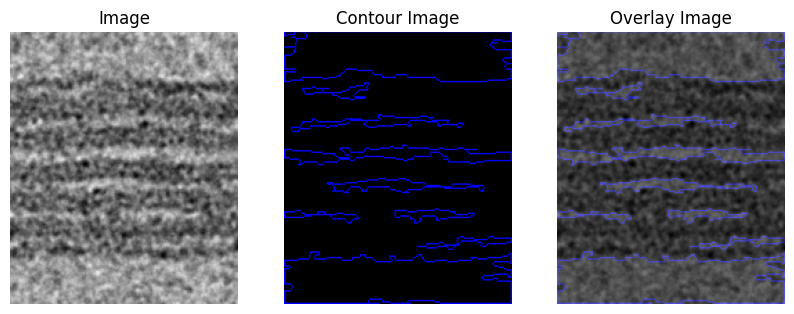

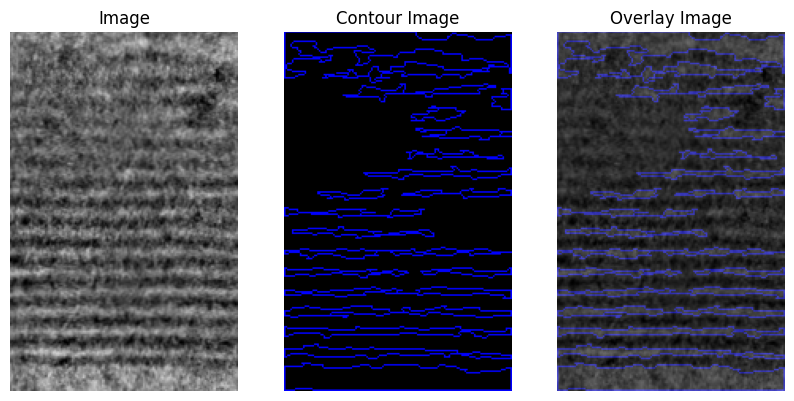

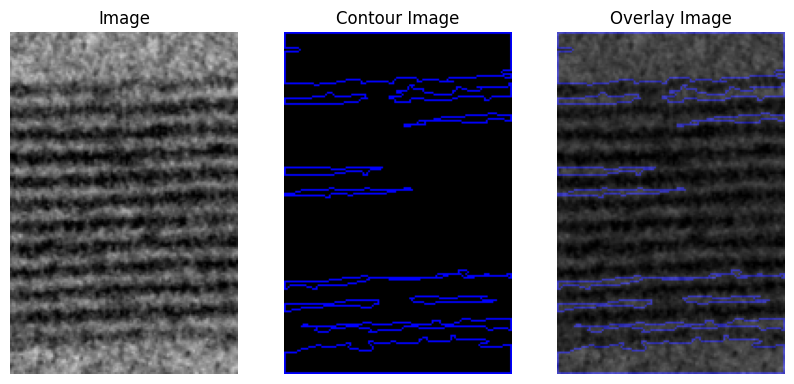

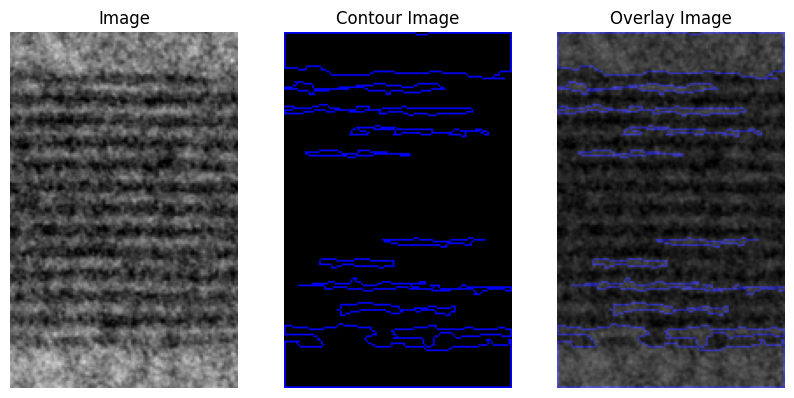

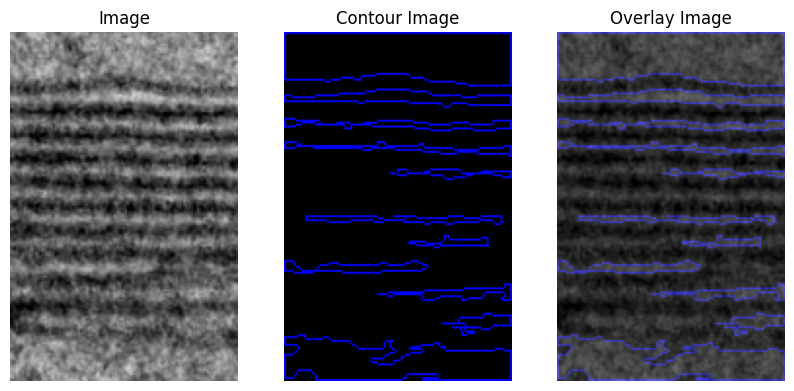

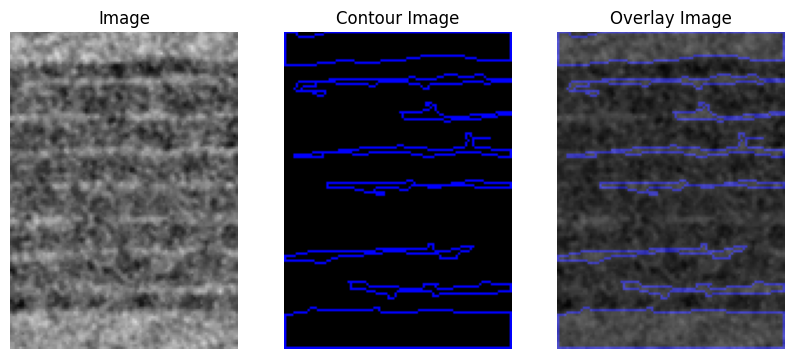

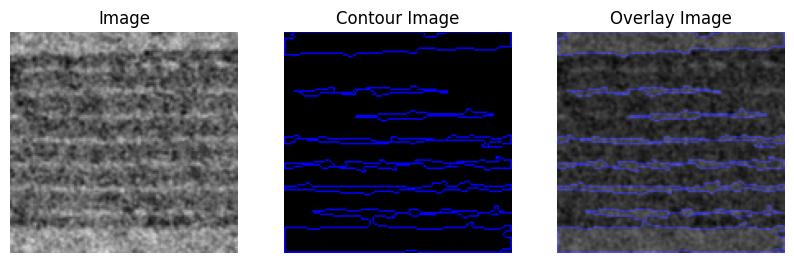

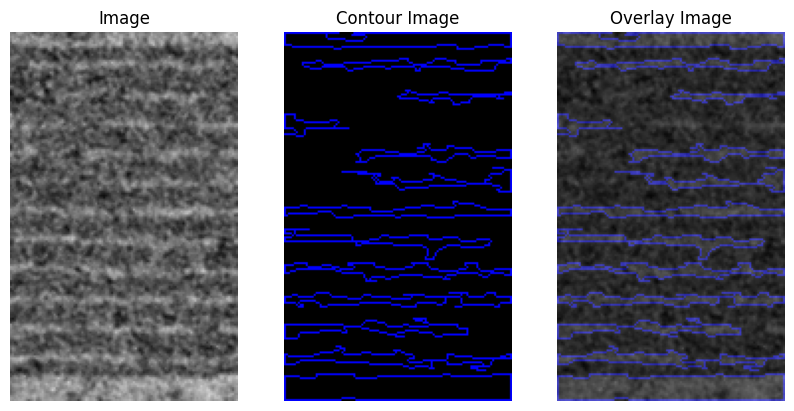

In [16]:
images = glob.glob("roi_images/*.png")


for filename in images[0:10]:
    print(filename)
    processed = process_image_strip(filename)
    
    print(processed["closing"].shape)
    print(processed["image"].shape)
    
    image_name = os.path.basename(filename)
    cv2.imwrite(f"output/{image_name.strip(".png")}_thresholded.png", processed["thresholded"])

    image = processed["image"]
    filtered_contours = processed["filtered_contours"]
    
    # draw the contours on the image
    contour_image = numpy.zeros_like(image)
    cv2.drawContours(contour_image, filtered_contours, -1, (255, 255, 255), 1)

    # save the contour image
    cv2.imwrite(f"output/{image_name.strip(".png")}_contours.png", contour_image)

    # create rgb copy of original image
    rgb_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # # create a red contour image
    contour_image = numpy.zeros_like(rgb_image)

    cv2.drawContours(contour_image, filtered_contours, -1, (0, 0, 255), 1)

    # create an image with the RGB image and the contour image overlaid
    overlay = cv2.addWeighted(rgb_image, 0.5, contour_image, 0.5, 0)
    
    cv2.imwrite(f"output/{image_name.strip(".png")}_overlay.png", overlay)
    
    # plot the rgb_image, the contour image, and then the overlay
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_image)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(contour_image)
    plt.axis("off")
    plt.title("Contour Image")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Overlay Image")

    plt.savefig(f"output/{image_name.strip(".png")}_tryptich.png")